In [6]:
import torch
from IPython.display import clear_output
import matplotlib.pyplot as plt

device = torch.device("cuda")

# Data MultiTrends

In [2]:
import os
import torch
import pandas as pd
import numpy as np
from tqdm import tqdm
from PIL import Image, ImageFile
from torch.utils.data import DataLoader, TensorDataset
from torchvision.transforms import Resize, ToTensor, Normalize, Compose
from sklearn.preprocessing import MinMaxScaler
ImageFile.LOAD_TRUNCATED_IMAGES = True


class ZeroShotDataset():
    def __init__(self, data_df, img_root, gtrends, cat_dict, col_dict, fab_dict, trend_len):
        self.data_df = data_df
        self.gtrends = gtrends
        self.cat_dict = cat_dict
        self.col_dict = col_dict
        self.fab_dict = fab_dict
        self.trend_len = trend_len
        self.img_root = img_root

    def __len__(self):
        return len(self.data_df)

    def __getitem__(self, idx):
        return self.data_df.iloc[idx, :]

    def preprocess_data(self):
        data = self.data_df

        # Get the Gtrends time series associated with each product
        # Read the images (extracted image features) as well
        gtrends, image_features = [], []
        img_transforms = Compose([Resize((256, 256)), ToTensor(), Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])])
        for (idx, row) in tqdm(data.iterrows(), total=len(data), ascii=True):
            cat, col, fab, fiq_attr, start_date, img_path = row['category'], row['color'], row['fabric'], row['extra'], \
                row['release_date'], row['image_path']

            # Get the gtrend signal up to the previous year (52 weeks) of the release date
            gtrend_start = start_date - pd.DateOffset(weeks=52)
            cat_gtrend = self.gtrends.loc[gtrend_start:start_date][cat][-52:].values[:self.trend_len]
            col_gtrend = self.gtrends.loc[gtrend_start:start_date][col][-52:].values[:self.trend_len]
            fab_gtrend = self.gtrends.loc[gtrend_start:start_date][fab][-52:].values[:self.trend_len]

            cat_gtrend = MinMaxScaler().fit_transform(cat_gtrend.reshape(-1,1)).flatten()
            col_gtrend = MinMaxScaler().fit_transform(col_gtrend.reshape(-1,1)).flatten()
            fab_gtrend = MinMaxScaler().fit_transform(fab_gtrend.reshape(-1,1)).flatten()
            multitrends =  np.vstack([cat_gtrend, col_gtrend, fab_gtrend])


            # Read images
            img = Image.open(os.path.join(self.img_root, img_path)).convert('RGB')

            # Append them to the lists
            gtrends.append(multitrends)
            image_features.append(img_transforms(img))

        # Convert to numpy arrays
        gtrends = np.array(gtrends)

        # Remove non-numerical information
        data.drop(['external_code', 'season', 'release_date', 'image_path'], axis=1, inplace=True)

        # Create tensors for each part of the input/output
        item_sales, temporal_features = torch.FloatTensor(data.iloc[:, :12].values), torch.FloatTensor(
            data.iloc[:, 13:17].values)
        categories, colors, fabrics = [self.cat_dict[val] for val in data.iloc[:].category.values], \
                                       [self.col_dict[val] for val in data.iloc[:].color.values], \
                                       [self.fab_dict[val] for val in data.iloc[:].fabric.values]

        
        categories, colors, fabrics = torch.LongTensor(categories), torch.LongTensor(colors), torch.LongTensor(fabrics)
        gtrends = torch.FloatTensor(gtrends)
        images = torch.stack(image_features)

        return TensorDataset(item_sales, categories, colors, fabrics, temporal_features, gtrends, images)

    def get_loader(self, batch_size, train=True):
        print('Starting dataset creation process...')
        data_with_gtrends = self.preprocess_data()
        data_loader = None
        if train:
            data_loader = DataLoader(data_with_gtrends, batch_size=batch_size, shuffle=True, num_workers=4)
        else:
            data_loader = DataLoader(data_with_gtrends, batch_size=1, shuffle=False, num_workers=4)
        print('Done.')

        return data_loader

# GTM


In [3]:
import math
import torch
import torch.nn as nn
import torch.nn.functional as F
import pytorch_lightning as pl
from transformers import pipeline
from torchvision import models
from fairseq.optim.adafactor import Adafactor


class PositionalEncoding(nn.Module):
    def __init__(self, d_model, dropout=0.1, max_len=52):
        super(PositionalEncoding, self).__init__()
        self.dropout = nn.Dropout(p=dropout)

        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0).transpose(0, 1)
        self.register_buffer('pe', pe)

    def forward(self, x):
        x = x + self.pe[:x.size(0), :]
        return self.dropout(x)

class TimeDistributed(nn.Module):
    # Takes any module and stacks the time dimension with the batch dimenison of inputs before applying the module
    # Insipired from https://keras.io/api/layers/recurrent_layers/time_distributed/
    # https://discuss.pytorch.org/t/any-pytorch-function-can-work-as-keras-timedistributed/1346/4
    def __init__(self, module, batch_first=True):
        super(TimeDistributed, self).__init__()
        self.module = module # Can be any layer we wish to apply like Linear, Conv etc
        self.batch_first = batch_first

    def forward(self, x):
        if len(x.size()) <= 2:
            return self.module(x)

        # Squash samples and timesteps into a single axis
        x_reshape = x.contiguous().view(-1, x.size(-1))  

        y = self.module(x_reshape)

        # We have to reshape Y
        if self.batch_first:
            y = y.contiguous().view(x.size(0), -1, y.size(-1))  # (samples, timesteps, output_size)
        else:
            y = y.view(-1, x.size(1), y.size(-1))  # (timesteps, samples, output_size)

        return y

class FusionNetwork(nn.Module):
    def __init__(self, embedding_dim, hidden_dim, use_img, use_text, dropout=0.2):
        super(FusionNetwork, self).__init__()
        
        self.img_pool = nn.AdaptiveAvgPool2d((1,1))
        self.img_linear = nn.Linear(2048, embedding_dim)
        self.use_img = use_img
        self.use_text = use_text
        input_dim = embedding_dim + (embedding_dim*use_img) + (embedding_dim*use_text)
        self.feature_fusion = nn.Sequential(
            nn.BatchNorm1d(input_dim),
            nn.Linear(input_dim, input_dim, bias=False),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(input_dim, hidden_dim)
        )

    def forward(self, img_encoding, text_encoding, dummy_encoding):
        # Fuse static features together
        pooled_img = self.img_pool(img_encoding)
        condensed_img = self.img_linear(pooled_img.flatten(1))

        # Build input
        decoder_inputs = []
        if self.use_img == 1:
            decoder_inputs.append(condensed_img) 
        if self.use_text == 1:
            decoder_inputs.append(text_encoding) 
        decoder_inputs.append(dummy_encoding)
        concat_features = torch.cat(decoder_inputs, dim=1)

        final = self.feature_fusion(concat_features)
        # final = self.feature_fusion(dummy_encoding)

        return final

class GTrendEmbedder(nn.Module):
    def __init__(self, forecast_horizon, embedding_dim, use_mask, trend_len, num_trends,  gpu_num):
        super().__init__()
        self.forecast_horizon = forecast_horizon
        self.input_linear = TimeDistributed(nn.Linear(num_trends, embedding_dim))
        self.pos_embedding = PositionalEncoding(embedding_dim, max_len=trend_len)
        encoder_layer = nn.TransformerEncoderLayer(d_model=embedding_dim, nhead=4, dropout=0.2)
        self.encoder = nn.TransformerEncoder(encoder_layer, num_layers=2)
        self.use_mask = use_mask
        self.gpu_num = gpu_num

    def _generate_encoder_mask(self, size, forecast_horizon):
        mask = torch.zeros((size, size))
        split = math.gcd(size, forecast_horizon)
        for i in range(0, size, split):
            mask[i:i+split, i:i+split] = 1
        mask = mask.float().masked_fill(mask == 0, float('-inf')).masked_fill(mask == 1, float(0.0)).to('cuda:'+str(self.gpu_num))
        return mask
    
    def _generate_square_subsequent_mask(self, size):
        mask = (torch.triu(torch.ones(size, size)) == 1).transpose(0, 1)
        mask = mask.float().masked_fill(mask == 0, float('-inf')).masked_fill(mask == 1, float(0.0)).to('cuda:'+str(self.gpu_num))
        return mask

    def forward(self, gtrends):
        gtrend_emb = self.input_linear(gtrends.permute(0,2,1))
        gtrend_emb = self.pos_embedding(gtrend_emb.permute(1,0,2))
        input_mask = self._generate_encoder_mask(gtrend_emb.shape[0], self.forecast_horizon)
        if self.use_mask == 1:
            gtrend_emb = self.encoder(gtrend_emb, input_mask)
        else:
            gtrend_emb = self.encoder(gtrend_emb)
        return gtrend_emb
        
class TextEmbedder(nn.Module):
    def __init__(self, embedding_dim, cat_dict, col_dict, fab_dict, gpu_num):
        super().__init__()
        self.embedding_dim = embedding_dim
        self.cat_dict = {v: k for k, v in cat_dict.items()}
        self.col_dict = {v: k for k, v in col_dict.items()}
        self.fab_dict = {v: k for k, v in fab_dict.items()}
        self.word_embedder = pipeline('feature-extraction', model='bert-base-uncased')
        self.fc = nn.Linear(768, embedding_dim)
        self.dropout = nn.Dropout(0.1)
        self.gpu_num = gpu_num

    def forward(self, category, color, fabric):
        textual_description = [self.col_dict[color.detach().cpu().numpy().tolist()[i]] + ' ' \
                + self.fab_dict[fabric.detach().cpu().numpy().tolist()[i]] + ' ' \
                + self.cat_dict[category.detach().cpu().numpy().tolist()[i]] for i in range(len(category))]


        # Use BERT to extract features
        word_embeddings = self.word_embedder(textual_description)

        # BERT gives us embeddings for [CLS] ..  [EOS], which is why we only average the embeddings in the range [1:-1] 
        # We're not fine tuning BERT and we don't want the noise coming from [CLS] or [EOS]
        word_embeddings = [torch.FloatTensor(x[0][1:-1]).mean(axis=0) for x in word_embeddings] 
        word_embeddings = torch.stack(word_embeddings).to('cuda:'+str(self.gpu_num))
        
        # Embed to our embedding space
        word_embeddings = self.dropout(self.fc(word_embeddings))

        return word_embeddings

class ImageEmbedder(nn.Module):
    def __init__(self):
        super().__init__()
        # Img feature extraction
        resnet = models.resnet50(pretrained=True)
        modules = list(resnet.children())[:-2]
        self.resnet = nn.Sequential(*modules)
        for p in self.resnet.parameters():
            p.requires_grad = False

        # Fine tune resnet
        # for c in list(self.resnet.children())[6:]:
        #     for p in c.parameters():
        #         p.requires_grad = True
        
    def forward(self, images):        
        img_embeddings = self.resnet(images)  
        size = img_embeddings.size()
        out = img_embeddings.view(*size[:2],-1)

        return out.view(*size).contiguous() # batch_size, 2048, image_size/32, image_size/32

class DummyEmbedder(nn.Module):
    def __init__(self, embedding_dim):
        super().__init__()
        self.embedding_dim = embedding_dim
        self.day_embedding = nn.Linear(1, embedding_dim)
        self.week_embedding = nn.Linear(1, embedding_dim)
        self.month_embedding = nn.Linear(1, embedding_dim)
        self.year_embedding = nn.Linear(1, embedding_dim)
        self.dummy_fusion = nn.Linear(embedding_dim*4, embedding_dim)
        self.dropout = nn.Dropout(0.2)


    def forward(self, temporal_features):
        # Temporal dummy variables (day, week, month, year)
        d, w, m, y = temporal_features[:, 0].unsqueeze(1), temporal_features[:, 1].unsqueeze(1), \
            temporal_features[:, 2].unsqueeze(1), temporal_features[:, 3].unsqueeze(1)
        d_emb, w_emb, m_emb, y_emb = self.day_embedding(d), self.week_embedding(w), self.month_embedding(m), self.year_embedding(y)
        temporal_embeddings = self.dummy_fusion(torch.cat([d_emb, w_emb, m_emb, y_emb], dim=1))
        temporal_embeddings = self.dropout(temporal_embeddings)

        return temporal_embeddings

class TransformerDecoderLayer(nn.Module):

    def __init__(self, d_model, nhead, dim_feedforward=2048, dropout=0.1, activation="relu"):
        super(TransformerDecoderLayer, self).__init__()
        
        self.multihead_attn = nn.MultiheadAttention(d_model, nhead, dropout=dropout)

        # Implementation of Feedforward model
        self.linear1 = nn.Linear(d_model, dim_feedforward)
        self.dropout = nn.Dropout(dropout)
        self.linear2 = nn.Linear(dim_feedforward, d_model)

        self.norm2 = nn.LayerNorm(d_model)
        self.norm3 = nn.LayerNorm(d_model)
        self.dropout2 = nn.Dropout(dropout)
        self.dropout3 = nn.Dropout(dropout)

        self.activation = F.relu

    def __setstate__(self, state):
        if 'activation' not in state:
            state['activation'] = F.relu
        super(TransformerDecoderLayer, self).__setstate__(state)

    def forward(self, tgt, memory, tgt_mask = None, memory_mask = None, tgt_key_padding_mask = None, 
            memory_key_padding_mask = None):

        tgt2, attn_weights = self.multihead_attn(tgt, memory, memory)
        tgt = tgt + self.dropout2(tgt2)
        tgt = self.norm2(tgt)
        tgt2 = self.linear2(self.dropout(self.activation(self.linear1(tgt))))
        tgt = tgt + self.dropout3(tgt2)
        tgt = self.norm3(tgt)
        return tgt, attn_weights

# class GTM(pl.LightningModule):
class GTM(nn.Module):
    def __init__(self, embedding_dim, hidden_dim, output_dim, num_heads, num_layers, use_text, use_img, \
                cat_dict, col_dict, fab_dict, trend_len, num_trends, gpu_num, use_encoder_mask=1, autoregressive=False):
        super().__init__()
        self.hidden_dim = hidden_dim
        self.embedding_dim = embedding_dim
        self.output_len = output_dim
        self.use_encoder_mask = use_encoder_mask
        self.autoregressive = autoregressive
        self.gpu_num = gpu_num
        # self.save_hyperparameters()

         # Encoder
        self.dummy_encoder = DummyEmbedder(embedding_dim)
        self.image_encoder = ImageEmbedder()
        self.text_encoder = TextEmbedder(embedding_dim, cat_dict, col_dict, fab_dict, gpu_num)
        self.gtrend_encoder = GTrendEmbedder(output_dim, hidden_dim, use_encoder_mask, trend_len, num_trends, gpu_num)
        self.static_feature_encoder = FusionNetwork(embedding_dim, hidden_dim, use_img, use_text)

        # Decoder
        self.decoder_linear = TimeDistributed(nn.Linear(1, hidden_dim))
        decoder_layer = TransformerDecoderLayer(d_model=self.hidden_dim, nhead=num_heads, \
                                                dim_feedforward=self.hidden_dim * 4, dropout=0.1)
        
        if self.autoregressive: self.pos_encoder = PositionalEncoding(hidden_dim, max_len=12)
        self.decoder = nn.TransformerDecoder(decoder_layer, num_layers)
        
        self.decoder_fc = nn.Sequential(
            nn.Linear(hidden_dim, self.output_len if not self.autoregressive else 1),
            nn.Dropout(0.2)
        )
    def _generate_square_subsequent_mask(self, size):
        mask = (torch.triu(torch.ones(size, size)) == 1).transpose(0, 1)
        mask = mask.float().masked_fill(mask == 0, float('-inf')).masked_fill(mask == 1, float(0.0)).to('cuda:'+str(self.gpu_num))
        return mask

    def forward(self, category, color, fabric, temporal_features, gtrends, images):
        # Encode features and get inputs
        img_encoding = self.image_encoder(images)
        dummy_encoding = self.dummy_encoder(temporal_features)
        text_encoding = self.text_encoder(category, color, fabric)
        gtrend_encoding = self.gtrend_encoder(gtrends)

        # Fuse static features together
        static_feature_fusion = self.static_feature_encoder(img_encoding, text_encoding, dummy_encoding)

        if self.autoregressive == 1:
            # Decode
            tgt = torch.zeros(self.output_len, gtrend_encoding.shape[1], gtrend_encoding.shape[-1]).to('cuda:'+str(self.gpu_num))
            tgt[0] = static_feature_fusion
            tgt = self.pos_encoder(tgt)
            tgt_mask = self._generate_square_subsequent_mask(self.output_len)
            memory = gtrend_encoding
            decoder_out, attn_weights = self.decoder(tgt, memory, tgt_mask)
            forecast = self.decoder_fc(decoder_out)
        else:
            # Decode (generatively/non-autoregressively)
            tgt = static_feature_fusion.unsqueeze(0)
            memory = gtrend_encoding
            decoder_out, attn_weights = self.decoder(tgt, memory)
            forecast = self.decoder_fc(decoder_out)

        return forecast.view(-1, self.output_len), attn_weights

    def configure_optimizers(self):
        optimizer = Adafactor(self.parameters(),scale_parameter=True, relative_step=True, warmup_init=True, lr=None)
    
        return [optimizer]


    def training_step(self, train_batch, batch_idx):
        item_sales, category, color, fabric, temporal_features, gtrends, images = train_batch 
        forecasted_sales, _ = self.forward(category, color, fabric, temporal_features, gtrends, images)
        loss = F.mse_loss(item_sales, forecasted_sales.squeeze())
        self.log('train_loss', loss)

        return loss

    def validation_step(self, test_batch, batch_idx):
        item_sales, category, color, fabric, temporal_features, gtrends, images = test_batch 
        forecasted_sales, _ = self.forward(category, color, fabric, temporal_features, gtrends, images)
        
        return item_sales.squeeze(), forecasted_sales.squeeze()

    def validation_epoch_end(self, val_step_outputs):
        item_sales, forecasted_sales = [x[0] for x in val_step_outputs], [x[1] for x in val_step_outputs]
        item_sales, forecasted_sales = torch.stack(item_sales), torch.stack(forecasted_sales)
        rescaled_item_sales, rescaled_forecasted_sales = item_sales*1065, forecasted_sales*1065 # 1065 is the normalization factor (max of the sales of the training set)
        loss = F.mse_loss(item_sales, forecasted_sales.squeeze())
        mae = F.l1_loss(rescaled_item_sales, rescaled_forecasted_sales)
        self.log('val_mae', mae)
        self.log('val_loss', loss)

        print('Validation MAE:', mae.detach().cpu().numpy(), 'LR:', self.optimizers().param_groups[0]['lr'])

/home/sh-sungho.park/anaconda3/envs/cudatest/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2023-10-30 10:39:39 | INFO | fairseq.tasks.text_to_speech | Please install tensorboardX: pip install tensorboardX


# Train

### Set

In [4]:
import os
import argparse
import wandb
import torch
import pandas as pd
import pytorch_lightning as pl
from pytorch_lightning import loggers as pl_loggers
from pathlib import Path
from datetime import datetime

args = {
    "data_folder": "../visuelle/",
    "log_dir": "log",
    "seed": 21,
    "epochs": 200,
    "gpu_num": 0,

    "model_type": "GTM",
    "use_trends": 1,
    "use_img": 1,
    "use_text": 1,
    "trend_len": 52,
    "num_trends": 3,
    "batch_size": 128,
    "embedding_dim": 32,
    "hidden_dim": 64,
    "output_dim": 12,
    "use_encoder_mask": 1,
    "autoregressive": 0,
    "num_attn_heads": 4,
    "num_hidden_layers": 1,
}
# Seeds for reproducibility (By default we use the number 21)
pl.seed_everything(args["seed"])

# Load sales data
train_df = pd.read_csv(Path(args["data_folder"] + 'train.csv'), parse_dates=['release_date'])
test_df = pd.read_csv(Path(args["data_folder"] + 'test.csv'), parse_dates=['release_date'])

# Load category and color encodings
cat_dict = torch.load(Path(args["data_folder"] + 'category_labels.pt'))
col_dict = torch.load(Path(args["data_folder"] + 'color_labels.pt'))
fab_dict = torch.load(Path(args["data_folder"] + 'fabric_labels.pt'))

# Load Google trends
gtrends = pd.read_csv(Path(args["data_folder"] + 'gtrends.csv'), index_col=[0], parse_dates=True)

# Model Training
# Define model saving procedure
dt_string = datetime.now().strftime("%d-%m-%Y-%H-%M-%S")

model_savename = args["model_type"]

checkpoint_callback = pl.callbacks.ModelCheckpoint(
    dirpath=args["log_dir"] + '/'+args["model_type"],
    filename=model_savename+'---{epoch}---'+dt_string,
    monitor='val_mae',
    mode='min',
    save_top_k=1
)

# If you wish to use Tensorboard you can change the logger to:
# tb_logger = pl_loggers.TensorBoardLogger(args.log_dir+'/', name=model_savename)
trainer = pl.Trainer(
                    gpus=[args["gpu_num"]], 
                    max_epochs=args["epochs"], check_val_every_n_epoch=5,
                    callbacks=[checkpoint_callback]
                        )

train_loader = ZeroShotDataset(train_df, Path(args["data_folder"] + '/images'), gtrends, cat_dict, col_dict,
                                fab_dict, args["trend_len"]).get_loader(batch_size=args["batch_size"], train=True)
test_loader = ZeroShotDataset(test_df, Path(args["data_folder"] + '/images'), gtrends, cat_dict, col_dict,
                                fab_dict, args["trend_len"]).get_loader(batch_size=1, train=False)

Global seed set to 21
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs


Starting dataset creation process...


100%|##########| 5080/5080 [00:52<00:00, 97.62it/s] 


Done.
Starting dataset creation process...


100%|##########| 497/497 [00:06<00:00, 77.66it/s]

Done.


### Train loop

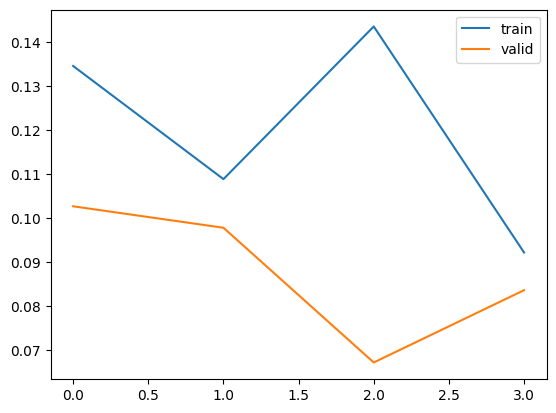

 4:0/40 mean_loss: 0.11721235513687134

KeyboardInterrupt: 

In [7]:
model = GTM(
    embedding_dim=args["embedding_dim"],
    hidden_dim=args["hidden_dim"],
    output_dim=args["output_dim"],
    num_heads=args["num_attn_heads"],
    num_layers=args["num_hidden_layers"],
    cat_dict=cat_dict,
    col_dict=col_dict,
    fab_dict=fab_dict,
    use_text=args["use_text"],
    use_img=args["use_img"],
    trend_len=args["trend_len"],
    num_trends=args["num_trends"],
    use_encoder_mask=args["use_encoder_mask"],
    autoregressive=args["autoregressive"],
    gpu_num=args["gpu_num"]
)
model.to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)
loss_fn = torch.nn.MSELoss()

# for train_batch in train_loader:
#     item_sales, category, color, fabric, temporal_features, gtrends, images = train_batch 
#     forecasted_sales, _ = model(category.to(device), color.to(device), fabric.to(device), temporal_features.to(device), gtrends.to(device), images.to(device))
#     loss = F.mse_loss(item_sales.to(device), forecasted_sales.squeeze())
#     print(loss)
#     break

def train(epoch):
    model.train()
    total_len = len(train_loader)
    total_loss = 0
    for n, train_batch in enumerate(train_loader):        
        # Train
        item_sales, category, color, fabric, temporal_features, gtrends, images = train_batch 
        forecasted_sales, _ = model(category.to(device), color.to(device), fabric.to(device), temporal_features.to(device), gtrends.to(device), images.to(device))
        loss = F.mse_loss(item_sales.to(device), forecasted_sales.squeeze())
        loss.backward()
        optimizer.step()

        # Report
        total_loss += loss.item()
        mean_loss = total_loss / (n+1)
        print(f"\r {epoch}:{n}/{total_len} mean_loss: {mean_loss}", end="")

    print()
    return mean_loss

def val():
    model.eval()
    total_len = len(test_loader)
    total_loss = 0
    for n, valid_batch in enumerate(test_loader):
        # Pred
        with torch.no_grad():
            item_sales, category, color, fabric, temporal_features, gtrends, images = valid_batch 
            forecasted_sales, _ = model(category.to(device), color.to(device), fabric.to(device), temporal_features.to(device), gtrends.to(device), images.to(device))
            loss = F.mse_loss(item_sales.to(device), forecasted_sales.squeeze())

            # Report
            total_loss += loss.item()
            mean_loss = total_loss / (n+1)
            return mean_loss
 
def plot(train_loss_li, val_loss_li):
    # Plot loss
    clear_output(wait=True)
    plt.plot(train_loss_li, label="train")
    plt.plot(val_loss_li, label="valid")
    plt.legend()
    plt.show()   

epoch = 1000
train_loss_li, val_loss_li = [], []
for e in range(epoch):
    train_loss = train(e) # Train
    val_loss = val()

    train_loss_li.append(train_loss)
    val_loss_li.append(val_loss)
    plot(train_loss_li, val_loss_li)

In [ ]:
# import os
# import argparse
# import wandb
# import torch
# import pandas as pd
# import pytorch_lightning as pl
# from pytorch_lightning import loggers as pl_loggers
# from pathlib import Path
# from datetime import datetime

# os.environ["TOKENIZERS_PARALLELISM"] = "false"


# def run(args):
#     print(args)
#     # Seeds for reproducibility (By default we use the number 21)
#     pl.seed_everything(args["seed"])

#     # Load sales data
#     train_df = pd.read_csv(Path(args["data_folder"] + 'train.csv'), parse_dates=['release_date'])
#     test_df = pd.read_csv(Path(args["data_folder"] + 'test.csv'), parse_dates=['release_date'])

#     # Load category and color encodings
#     cat_dict = torch.load(Path(args["data_folder"] + 'category_labels.pt'))
#     col_dict = torch.load(Path(args["data_folder"] + 'color_labels.pt'))
#     fab_dict = torch.load(Path(args["data_folder"] + 'fabric_labels.pt'))

#     # Load Google trends
#     gtrends = pd.read_csv(Path(args["data_folder"] + 'gtrends.csv'), index_col=[0], parse_dates=True)

#     model = GTM(
#         embedding_dim=args["embedding_dim"],
#         hidden_dim=args["hidden_dim"],
#         output_dim=args["output_dim"],
#         num_heads=args["num_attn_heads"],
#         num_layers=args["num_hidden_layers"],
#         cat_dict=cat_dict,
#         col_dict=col_dict,
#         fab_dict=fab_dict,
#         use_text=args["use_text"],
#         use_img=args["use_img"],
#         trend_len=args["trend_len"],
#         num_trends=args["num_trends"],
#         use_encoder_mask=args["use_encoder_mask"],
#         autoregressive=args["autoregressive"],
#         gpu_num=args["gpu_num"]
#     )

#     # Model Training
#     # Define model saving procedure
#     dt_string = datetime.now().strftime("%d-%m-%Y-%H-%M-%S")

#     model_savename = args["model_type"]

#     checkpoint_callback = pl.callbacks.ModelCheckpoint(
#         dirpath=args["log_dir"] + '/'+args["model_type"],
#         filename=model_savename+'---{epoch}---'+dt_string,
#         monitor='val_mae',
#         mode='min',
#         save_top_k=1
#     )

#     # If you wish to use Tensorboard you can change the logger to:
#     # tb_logger = pl_loggers.TensorBoardLogger(args.log_dir+'/', name=model_savename)
#     trainer = pl.Trainer(
#                         gpus=[args["gpu_num"]], 
#                         max_epochs=args["epochs"], check_val_every_n_epoch=5,
#                         callbacks=[checkpoint_callback]
#                          )

#     train_loader = ZeroShotDataset(train_df, Path(args["data_folder"] + '/images'), gtrends, cat_dict, col_dict,
#                                    fab_dict, args["trend_len"]).get_loader(batch_size=args["batch_size"], train=True)
#     test_loader = ZeroShotDataset(test_df, Path(args["data_folder"] + '/images'), gtrends, cat_dict, col_dict,
#                                   fab_dict, args["trend_len"]).get_loader(batch_size=1, train=False)

#     # Fit model
#     trainer.fit(model, train_dataloaders=train_loader,
#                 val_dataloaders=test_loader)

#     # Print out path of best model
#     print(checkpoint_callback.best_model_path)

# args = {
#     "data_folder": "../visuelle/",
#     "log_dir": "log",
#     "seed": 21,
#     "epochs": 200,
#     "gpu_num": 0,

#     "model_type": "GTM",
#     "use_trends": 1,
#     "use_img": 1,
#     "use_text": 1,
#     "trend_len": 52,
#     "num_trends": 3,
#     "batch_size": 128,
#     "embedding_dim": 32,
#     "hidden_dim": 64,
#     "output_dim": 12,
#     "use_encoder_mask": 1,
#     "autoregressive": 0,
#     "num_attn_heads": 4,
#     "num_hidden_layers": 1,
# }

# run(args)